# Chapter 04 시계열 데이터의 시뮬레이션

* 발견적 시뮬레이션
* 이산 사건 시뮬레이션
* 물리기반 시뮬레이션

## 4.2 코드로 보는 시뮬레이션

### 4.2.1 스스로 직접 만들어보기
    시뮬레이션 프로그래밍을 할 때는 시스템에 적용되는 논리적인 규칙을 명심해야함
    즉, 데이터를 논리적인 규칙에 맞춰 타당하게끔 만들어야한다는것
    예를 들어 사건의 발생의 순서가 비논리적으로 구성되지 않도록 보장

### 회원 자격에 대한 세계관 정의(회원 수, 가입 시점, 상태 정보를 고려해볼 수 있음)

In [1]:
# 회원 상태
years = ['2014', '2015', '2016', '2017', '2018']
memberStatus = ['bronze', 'silver', 'gold', 'inactive']

# np.random.choice의 p 인수를 조절하여
# 각 부류의 발생 확률을 달리하여 데이터를 생성
import numpy as np
import pandas as pd

memberYears = np.random.choice(years, 1000, p=[0.1, 0.1, 0.15, 0.30, 0.35])
memberStats = np.random.choice(memberStatus, 1000, p=[0.5, 0.3, 0.1, 0.1])

yearJoined = pd.DataFrame({'yearJoined':memberYears,
                           'memberStats':memberStats})

### 주별로 회원의 이메일 열람 시점을 나타내는 테이블 만들기
한 주에 이메일 세 통을 보내는 기관의 행동을 정의하고,<br/>
이메일에 관한 회원들의 행동 패턴은 다음과 같이 정의
* 이메일을 열람한 적이 없음
* 일정한 수준의 이메일 열람 및 참여율
* 참여 수준의 증감

In [2]:
NUM_EMAILS_SENT_WEEKLY = 3
# 서로 다른 패턴을 위한 몇 가지 함수를 정의
def never_opens(period_rng):    # 이메일을 한 번도 열람하지 않은 회원
    return []

def constant_open_rate(period_rng):     # 매주 같은 양의 이메일을 열람한 회원
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
    num_opened = np.random.binomial(n, p, len(period_rng))
    return num_opened

def increasing_open_rate(period_rng):   # 매주 열람한 이메일의 양이 늘어나는 회원
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))

def decreasing_open_rate(period_rng):   # 매주 열람한 이메일의 양이 줄어드는 회원
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5, 0.99))

def open_rate_with_factor_change(period_rng, fac):
    if len(period_rng) < 1:
        return []
    times = np.random.randint(0, len(period_rng), int(0.1 * len(period_rng)))
    num_opened = np.zeros(len(period_rng))
    for prd in range(0, len(period_rng), 2):
        try:
            n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
            num_opened[prd:(prd + 2)] = np.random.binomial(n, p, 2)
            p = max(min(1, p * fac), 0)
        except:
            num_opened[prd] = np.random.binomial(n, p, 1)
    for t in range(len(times)):
        num_opened[times[t]] = 0
    return num_opened
            

### 기부 행동을 모델링하는 시스템
회원의 행동을 정의하는 가설을 고려한 모델을 만들고,<br/>
그 가설에 기반한 시뮬레이션이 실제 데이터와 맞아떨어지는지 검증<br/>
여기서는 이메일 열람 횟수에 따라 기부행동을 정확히 결정하진 않지만, 약간은 느슨히 연결할것임

In [7]:
# 기부 행동
def produce_donations(period_rng, member_behavior, num_emails,
                                    use_id, member_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500,
                                            1000, 1500, 2000])
    member_has = np.random.choice(donation_amounts)
    email_fraction = num_emails / (NUM_EMAILS_SENT_WEEKLY * len(period_rng))
    member_gives = member_has * email_fraction
    member_gives_idx = np.where(member_gives >= donation_amounts)[0][-1]
    member_gives_idx = max(min(member_gives_idx, len(donation_amounts) -2), 1)

    num_times_gave = np.random.poisson(2) * (2018 - member_join_year)
    times = np.random.randint(0, len(period_rng), num_times_gave)
    dons = pd.DataFrame({'member' : [],
                         'amount' : [],
                         'timestamp' : []})
    
    for n in range(num_times_gave):
        donation = donation_amounts[member_gives_idx + np.random.binomial(1, .3)]
        ts = str(period_rng[times[n]].start_time + random_weekly_time_delta())
        dons = dons.append(pd.DataFrame(
                {'member' : [use_id],
                 'amount' : [donation],
                 'timestamp' : [ts]}))
        
        if dons.shape[0] > 0:
            dons = dons[dons.amount != 0]
            # 기부액이 0인 경우에는 보고하지 않음
            # 실세계에서 이런 정보는 데이터베이스에 반영되지 않음
            
            return dons

# 특정 주 내의 시간을 무작위로 고르기 위한 유틸리티 함수
def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11, 23)]
    minute_of_hour = [m for m in range(60)]
    second_of_minute = [s for s in range(60)]
    return pd.Timedelta(str(np.random.choice(days_of_week)) + "days") +\
           pd.Timedelta(str(np.random.choice(hours_of_day)) + "hours") +\
           pd.Timedelta(str(np.random.choice(minute_of_hour)) + "minutes") +\
           pd.Timedelta(str(np.random.choice(second_of_minute)) + "seconds")

In [4]:
# 함수 사용법 익혀봄
t = np.array([10,20,30,40,50])


a = 2
b = 1/3
c = np.array([0, 25, 50, 75, 100, 250, 500,1000, 1500, 2000])

np.random.choice(t)

np.where(25 >= c)[0][-1]
np.random.poisson(2)

2

### 특정회원의 사건을 시뮬레이션 하는데 필요한 모든 코드 요소 모음

In [15]:
behaviors = [never_opens, constant_open_rate, increasing_open_rate, decreasing_open_rate]
member_behaviors = np.random.choice(behaviors, 1000, [0.2, 0.5, 0.1, 0.2])

rng = pd.period_range('2015-02-14', '2018-06-01', freq='W')
emails = pd.DataFrame({'member' : [],
                       'week' : [],
                       'emailsOpened' : []})
donations = pd.DataFrame({'member' : [],
                          'amount' : [],
                          'timestamp' : []})

for idx in range(yearJoined.shape[0]):
    # 회원이 가입한 시기를 무작위로 생성
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) + \
                pd.Timedelta(str(np.random.randint(0, 365)) + ' days')
    join_date = min(join_date, pd.Timestamp('2018-06-01')).to_period(freq='W')

    # 가입 전에는 어떤 행동에 대한 타임스탬프가 없어야함
    member_rng = rng[rng > join_date]

    if len(member_rng) < 1:
        continue

    info = member_behaviors[idx](member_rng)
    if len(info) == len(member_rng):
        emails = emails.append(pd.DataFrame(
            {'member' : [idx] * len(info),
             'week' : [str(r.start_time) for r in member_rng],
             'emailsOpened' : info}))
        donations = donations.append(
            produce_donations(member_rng, member_behaviors[idx],
                              sum(info), idx, join_date.year))

### 위 시뮬레이터를 기반으로한 월마다 발생한 기부의 총합에 대한 도표

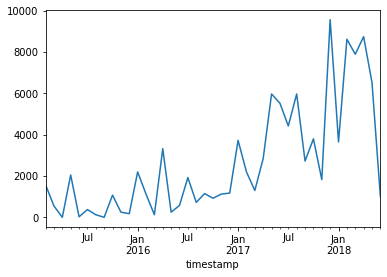

In [16]:
import matplotlib.pyplot as plt

df = donations
df.set_index(pd.to_datetime(df.timestamp), inplace=True)
df.sort_index(inplace=True)
df.groupby(pd.Grouper(freq='M')).amount.sum().plot()

뒷부분은 추가적인 공부후 보는것이 나아보임...